In [1]:
import matplotlib.pyplot as plt
import numpy as np
import openmm
from openmm import unit
from openmm import CustomExternalForce

%matplotlib inline

In [2]:
radius_negative = 105.0
box_length = 1000.0

In [3]:
def expected_function(x, box_length, rcut, delta, epsilon, sigma, alpha):
    return np.where(np.abs(x) < box_length / 2 - rcut - delta,
                    0.0,
                    4 * epsilon * (np.power(sigma / (box_length / 2 - np.abs(x) - delta), 12)
                                   - alpha * np.power(sigma / (box_length / 2 - np.abs(x) - delta), 6))
                    - 4 * epsilon * (np.power(sigma / rcut, 12)
                                     - alpha * np.power(sigma / rcut, 6)))

In [4]:
def get_potentials(x_positions, box_length, radius_negative, epsilon, alpha, platform_name="Reference"):
    
    # Set up system.
    system = openmm.System()
    
    box_length = box_length * unit.nanometer
    
    radius_negative = radius_negative * unit.nanometer


    system.setDefaultPeriodicBoxVectors([box_length, 0.0, 0.0],
                                        [0.0, box_length, 0.0],
                                        [0.0, 0.0, box_length])
    
    slj_potential = CustomExternalForce(
                "step(abs(x) - (box_length/2 - r_cut - delta)) * ("
                "4 * epsilon * "
                "((sigma/(box_length/2 - abs(x) - delta))^12 "
                "- alpha * (sigma / (box_length/2 - abs(x) - delta))^6)"
                "-4 * epsilon * "
                "((sigma/ r_cut)^12 "
                "- alpha * (sigma / r_cut)^6));"
                "delta = radius_negative -1;"
                "r_cut = radius_negative * 2^(1/6)"
            )


    slj_potential.addGlobalParameter("box_length", box_length)
    slj_potential.addGlobalParameter("radius_negative", radius_negative)
    slj_potential.addGlobalParameter("epsilon", epsilon)
    slj_potential.addGlobalParameter("sigma", radius_negative)
    slj_potential.addGlobalParameter("alpha", alpha)
    #slj_potential.addPerParticleParameter("x")
    
     # Add forces.
    system.addForce(slj_potential)
    
    # Add a particle to the system 
    system.addParticle(mass=1.0)
    slj_potential.addParticle(0) #,[x_positions[0]])
    
    for force in system.getForces():
            print(f"Energy function: {force.getEnergyFunction()}")
            #print(f"Nonbonded method: {force.getNonbondedMethod()}, Cutoff distance: {force.getCutoffDistance()}")
            #assert force.usesPeriodicBoundaryConditions()
            #assert not force.getUseLongRangeCorrection()

    # Set up platform and context. The platform_name is typically Reference or CUDA.
    platform = openmm.Platform.getPlatformByName(platform_name)
    temperature = 298.0 * unit.kelvin
    dummy_integrator = openmm.LangevinIntegrator(
        temperature.value_in_unit(unit.kelvin), 0.0, 0.0)
    context = openmm.Context(system, dummy_integrator, platform)
    print(f"Using {context.getPlatform().getName()} platform.")
    if context.getPlatform().getName() == "CUDA":
        for cuda_property in ("Precision", "TempDirectory", "UseCpuPme", "DeviceIndex", "UseBlockingSync", "DeterministicForces"):
            print(f"{cuda_property}: {context.getPlatform().getPropertyValue(context, cuda_property)}")
    
    potential_energies = np.zeros(len(x_positions))
    for x_index, x_pos in enumerate(x_positions):

        
        #slj_potential.addParticle(0,[x_pos])
        #slj_potential.addParticle(0,[radiusN])

        #potential_energies = np.zeros(len(x_positions))
        #for x_index, x_pos in enumerate(x_positions):
        context.setPositions([[x_pos, 0.0, 0.0]])
        state = context.getState(getEnergy=True)
        #slj_potential.addParticle(0,[x_pos])
       # print(state.getPotentialEnergy())
        
        potential_energies[x_index] = (
            state.getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
            #/ (unit.BOLTZMANN_CONSTANT_kB * temperature * unit.AVOGADRO_CONSTANT_NA)
        )
        
    
    return potential_energies

In [5]:
x_positions = np.linspace(-box_length / 2 + 100, box_length / 2 - 100, num=1000)

potential_vals = get_potentials(x_positions, box_length, radius_negative, 1, 0)

Energy function: step(abs(x) - (box_length/2 - r_cut - delta)) * (4 * epsilon * ((sigma/(box_length/2 - abs(x) - delta))^12 - alpha * (sigma / (box_length/2 - abs(x) - delta))^6)-4 * epsilon * ((sigma/ r_cut)^12 - alpha * (sigma / r_cut)^6));delta = radius_negative -1;r_cut = radius_negative * 2^(1/6)
Using Reference platform.


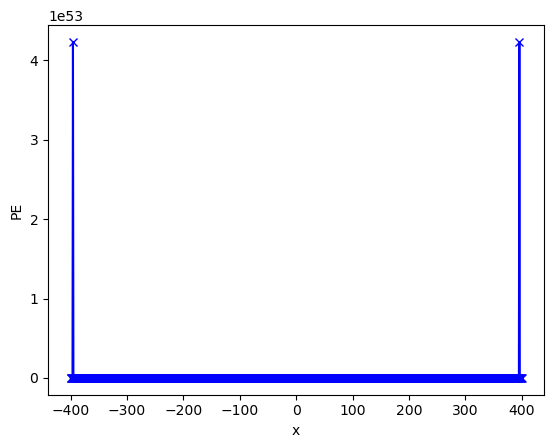

In [9]:
x_positions_exp = np.linspace(-box_length / 2 + 200, box_length / 2 - 200, num=10000)
pots = expected_function(x_positions_exp, box_length, radius_negative*(2.0**(1.0/6.0)),
                         radius_negative-1, 1, radius_negative, 0)

plt.plot(x_positions_exp, pots, color="k")

plt.plot(x_positions, potential_vals, color='blue', marker="x")
plt.xlabel("x")
plt.ylabel("PE")


plt.show()